We create a method for the analysis of covariance matrices through the Euler characteristic by constructing an edge weighted graph and measuring the topology of the graph through an edge filtration. 

In [6]:
#Data Processing Tools
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import scipy
from scipy.stats import zscore
from nilearn.connectome import ConnectivityMeasure


#Create progress bar
from tqdm.notebook import tqdm

#Formatting
import matplotlib
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale = 1.5)
sns.set_style('whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [10, 7]

Function to construct an adjaceny matrix (A) at each filtration threshold and compute the EC of this thresholded graph.

In [7]:
def euler_char(A,thresh):
    ECs = []
    A = A - np.identity(np.shape(A)[0])
    
    for t in thresh:

        M = np.array((A <= t)*1)
                
        #Number Edges
        Edges = np.sum(M)/2
        
        #Number Vertices
        Vertices = np.shape(A)[0]
        
        #Betti 1
        EC = Vertices - Edges
        
        ECs.append(EC)
        
    return ECs

In [8]:
with open('Sampled_train.pickle', 'rb') as handle:

    Sampled_train = pickle.load(handle)

Compute matrices from the corresponding time series for each process simulation.

In [9]:
MeanECs = []

corrmats = []

for j in tqdm(range(20)):

    baseline = Sampled_train[Sampled_train["faultNumber"] == j]
    
    ECs = []
    
    for i in range(20):
        baseline1 = baseline[baseline["simulationRun"]==i+1]
        baseline1 = baseline1.iloc[:,3::]
        precis_measure = ConnectivityMeasure(kind="precision", vectorize = False)
        corr_mat_all = precis_measure.fit_transform([np.asarray(baseline1)])
        corrmats.append(corr_mat_all)
        thresh = np.arange(0,1,.001)
        EC = euler_char(corr_mat_all[0,:,:],thresh)
        ECs.append(EC)

    ECz = np.stack(ECs).T

    MeanEC = np.mean(ECz,axis = 1)
    
    MeanECs.append(MeanEC)

  0%|          | 0/20 [00:00<?, ?it/s]

Example of time series data generated by each process simulation.

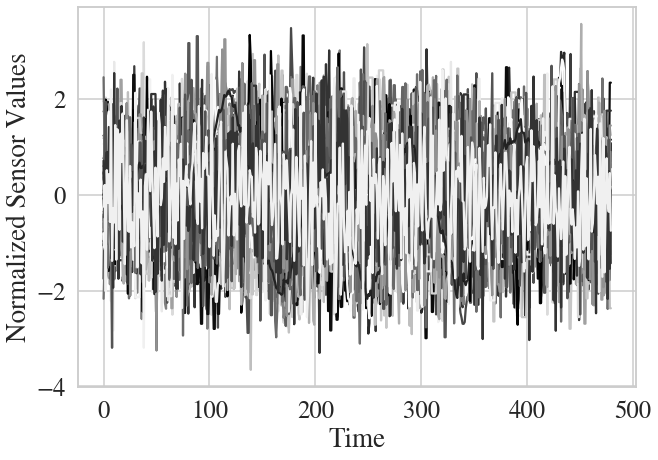

In [15]:
plt.figure()
plt.xlabel("Time")
plt.ylabel("Normalized Sensor Values")

colors = np.random.rand(52)
time_series = np.asarray(baseline1)

for i in range(52):
    plt.plot(zscore(time_series[:,i]),c = str(colors[i]))

Example matrix derived from time series data.

([<matplotlib.axis.XTick at 0x1efc2b7bcd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

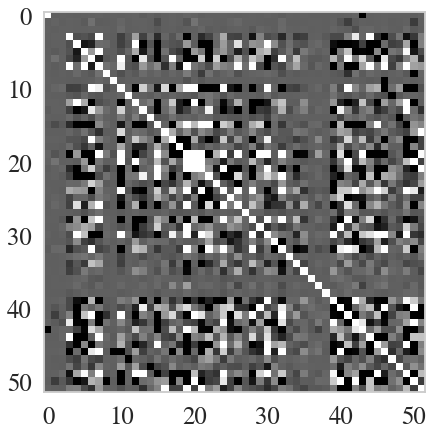

In [18]:
plt.imshow(corrmats[1][0,:,:],cmap = "gray",vmin = -0.03,vmax = .05)
plt.grid(False)
plt.xticks([0,10,20,30,40,50])

Plot EC curves for the data derived from the constructed matrices. 

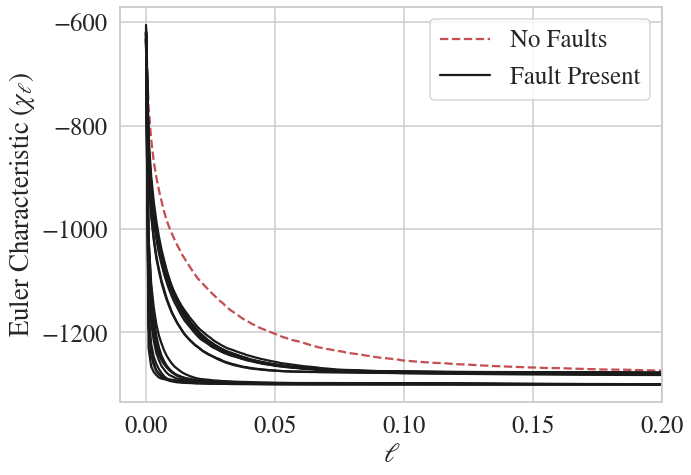

In [19]:
plt.plot(thresh,MeanECs[0],'--r',label ="No Faults")

for i in range(19):
    if i == 0:
        plt.plot(thresh,MeanECs[i+1],c = 'k',label = "Fault Present")
    
    else:
        plt.plot(thresh,MeanECs[i+1],c = 'k')
        
        
plt.xlim(-0.01,.2)
plt.legend()
plt.xlabel("$\ell$")
plt.ylabel(r"Euler Characteristic ($\chi_{\ell}$)")
plt.tight_layout()